In [118]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import classification_report
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import  ImageDataGenerator as imgen
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation

NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more. (https://numpy.org/doc/stable/)

Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities. (https://scikit-learn.org/stable/getting_started.html)

TensorFlow is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google's AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains. (https://pypi.org/project/tensorflow/)

Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. (https://matplotlib.org/)

Seaborn is a library for making statistical graphics in Python. It builds on top of matplotlib and integrates closely with pandas data structures. (https://seaborn.pydata.org/tutorial/introduction.html)

Keras is the high-level API of the TensorFlow platform: an approachable, highly-productive interface for solving machine learning problems, with a focus on modern deep learning. It provides essential abstractions and building blocks for developing and shipping machine learning solutions with high iteration velocity. The core data structures of Keras are layers and models. The simplest type of model is the Sequential model, a linear stack of layers. (https://keras.io/about/)

In [119]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

In [120]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs:", len(physical_devices))

Num of GPUs: 0


We checked for a GPU, since there is none operations will be done on the CPU.

In [121]:
train_dir = 'braintumor/Training' #directory of the training data

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    if label != ".DS_Store":
        #labels are pituitary, notumor, glioma, meningioma
        for image in os.listdir(train_dir + "//" + label):
            train_paths.append(train_dir + '//' + label + '//'+image)
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
print("Num of train images:", len(train_paths))

Num of train images: 5712


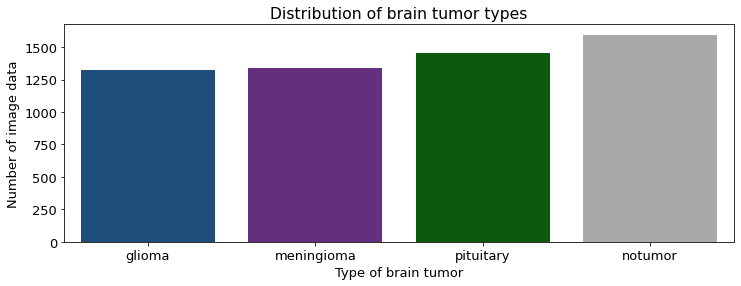

In [122]:
plt.figure(figsize=(12,4))
sns.countplot(train_labels, palette=['#104E8B','#68228B','#006400','#A9A9A9'])
plt.title('Distribution of brain tumor types')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of image data');

In [123]:
test_dir = 'braintumor/Testing' #directory of the test data

test_paths = []
test_labels = []

#preparing the list for test images.
for label in os.listdir(test_dir):
    if label != ".DS_Store":
        for image in os.listdir(test_dir + '//' + label):
            test_paths.append(test_dir + '//' + label + '//' + image)
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
print("Num of test images:", len(test_paths))

Num of test images: 1303


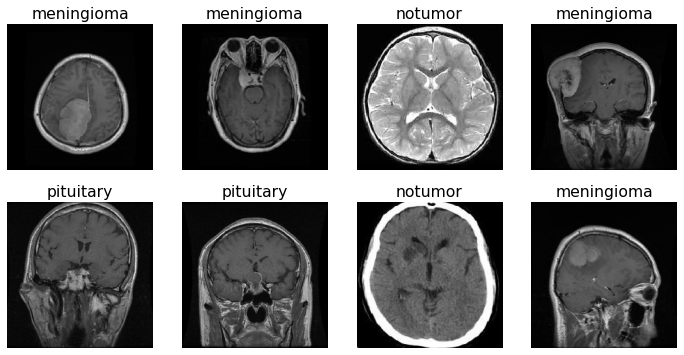

In [124]:
IMAGE_SIZE = 224

def open_image(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        images.append(image)
    return np.array(images)

#displaying some of the images.
images = open_image(train_paths[30:39])
labels = train_labels[30:39]

fig = plt.figure(figsize=(12, 6))

for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])

plt.rcParams.update({'font.size': 13})
plt.show()

In [125]:
seed(1)

# setting random seed in tensorflow
tf.random.set_seed(2) 

train_data_gen = imgen(rescale=1./255,
                                    shear_range=0.2,
                                    rotation_range=2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.15)

training_set = train_data_gen.flow_from_directory(directory="braintumor/Training",
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode='categorical',
                                                  subset="training",
                                                  batch_size=32)


validation_set = train_data_gen.flow_from_directory(directory="braintumor/Training",
                                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                        class_mode='categorical',
                                                        subset="validation",
                                                        batch_size=32)

test_data_gen = imgen(rescale=1./255)

testing_set = test_data_gen.flow_from_directory(directory="braintumor/Testing",
                                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                        class_mode='categorical',
                                                        batch_size=32,
                                                        shuffle = False)

prediction_data_gen = imgen(rescale=1./255)

prediction_set = prediction_data_gen.flow_from_directory(directory="braintumor/Prediction",
                                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                        class_mode='categorical',
                                                        batch_size=32,
                                                        shuffle = False)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1299 images belonging to 4 classes.
Found 75 images belonging to 4 classes.


ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

flow_from_directory generates a tf.data.Dataset from image files in a directory.

Target_size: Tuple of integers (height, width), defaults to (512, 512). The dimensions to which all images are found will be resized.

Seed: Optional random seed for shuffling and transformations.

Batch_size: Size of the batches of data (default: 32).

Subset : Subset of data (“training” or “validation”).

Shuffle: Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.

In [9]:
cnnmodel = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu'),
    Dropout(0.20),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.20),
    Dense(32, activation='relu'),
    Dropout(0.20),
    Dense(10, activation='relu'),
    Dropout(0.20),
    Dense(4, activation='softmax')
])

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             


2023-05-16 18:45:02.497216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 dropout (Dropout)           (None, 56, 56, 16)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 64)                3211328   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (

The convolutional layer performs the filtering step. The weights that ConvNet learns during training are primarily contained in its convolutional layers. These scales are called cores. The core works by scanning the image and producing a weighted pixel sum.

The activation function decides whether a particular neuron will fire or not based on the input it receives and passes it on to the next layer. The Rectified Linear Unit or ReLU is the most common activation function used due to its simple implementation and overcoming many other obstacles caused by other activation functions such as the Sigmoid. We also used the Softmax activation function in the model because it is used to classify multi-class datasets.

Max Pooling is a convolutional process where the kernel extracts the maximum value of the area it covers. Like max pooling, we can use average pooling. The ReLU (Detect) function in the function map ends up with a lot of “dead space”, we would like to condense the function map to keep only the most useful part of the function itself.

Dropout layer: This layer is used on any hidden layer but cannot be used on an output layer. This layer is mainly used to prevent the overfitting of our model.

Flatten layer: This layer is mainly used to convert multidimensional input to unidimensional output.

Dense layer: A simple layer of neurons where each neural network is interconnected.

Since our output will consist of any of the four classes glioma, meningioma, no tumor, and pituitary, we gave the output layer four units.

In [10]:
cnnmodel.compile(loss="categorical_crossentropy", optimizer = "Adam", metrics=["accuracy"])

In [11]:
history = cnnmodel.fit(training_set, validation_data=validation_set, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
152/152 [==============================] - 139s 902ms/step - loss: 1.1493 - accuracy: 0.4511 - val_loss: 0.9430 - val_accuracy: 0.6456
Epoch 2/50
152/152 [==============================] - 134s 882ms/step - loss: 0.8816 - accuracy: 0.6131 - val_loss: 0.8634 - val_accuracy: 0.6561
Epoch 3/50
152/152 [==============================] - 133s 877ms/step - loss: 0.8043 - accuracy: 0.6564 - val_loss: 0.8429 - val_accuracy: 0.6573
Epoch 4/50
152/152 [==============================] - 142s 933ms/step - loss: 0.7475 - accuracy: 0.6842 - val_loss: 0.8739 - val_accuracy: 0.6515
Epoch 5/50
152/152 [==============================] - 135s 888ms/step - loss: 0.6902 - accuracy: 0.7140 - val_loss: 0.7434 - val_accuracy: 0.7216
Epoch 6/50
152/152 [==============================] - 135s 887ms/step - loss: 0.6508 - accuracy: 0.7379 - val_loss: 0.7697 - val_accuracy: 0.7357
Epoch 7/50
152/152 [==============================] - 137s 897ms/step - loss: 0.6062 - accuracy: 0.7542 - val_loss: 0.8577 -

In [12]:
cnnmodel.evaluate(testing_set)

41/41 [==============================] - 12s 283ms/step - loss: 0.4590 - accuracy: 0.8537


[0.4589938223361969, 0.8537336587905884]

<Figure size 432x288 with 0 Axes>

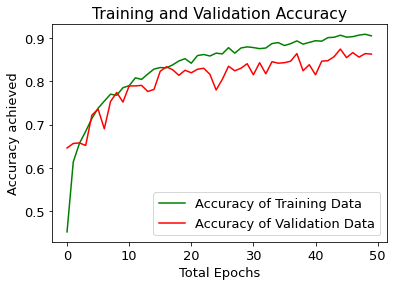

<Figure size 432x288 with 0 Axes>

In [13]:
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], 'green', label='Accuracy of Training Data')
plt.plot(epochs, history.history['val_accuracy'], 'red', label='Accuracy of Validation Data')
plt.xlabel('Total Epochs')
plt.ylabel('Accuracy achieved')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

In [126]:
if os.path.isfile('model/brain_tumor_detection_cnn.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn.h5')

if os.path.isfile('model/brain_tumor_detection_cnn2.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn2.h5')

if os.path.isfile('model/brain_tumor_detection_cnn3.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn3.h5')

if os.path.isfile('model/brain_tumor_detection_cnn4.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn4.h5')

if os.path.isfile('model/brain_tumor_detection_cnn5.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn5.h5')

if os.path.isfile('model/brain_tumor_detection_cnn6.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn6.h5')

if os.path.isfile('model/brain_tumor_detection_cnn7.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn7.h5')

if os.path.isfile('model/brain_tumor_detection_cnn8.h5') is False:
    cnnmodel.save('model/brain_tumor_detection_cnn8.h5')

from tensorflow.keras.models import load_model
cnn_model = load_model('model/brain_tumor_detection_cnn8.h5')

print(cnn_model.summary())
print(cnn_model.get_weights())
print(cnn_model.optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 dropout (Dropout)           (None, 56, 56, 16)        0

In [127]:
cnn_model.evaluate(testing_set)

41/41 [==============================] - 12s 261ms/step - loss: 0.4590 - accuracy: 0.8537


[0.4589938223361969, 0.8537336587905884]

In [130]:
labels = (training_set.class_indices)
labels = list(labels.keys())
test_labels=testing_set.classes 
print(test_labels)
predictions = cnn_model.predict(testing_set)
predictions = np.argmax(predictions, axis=1)
print(predictions)
print(classification_report(test_labels, predictions, target_names=labels))

[0 0 0 ... 3 3 3]
41/41 [==============================] - 11s 244ms/step
[0 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      glioma       0.94      0.73      0.82       297
  meningioma       0.80      0.68      0.73       303
     notumor       0.81      1.00      0.89       402
   pituitary       0.91      0.96      0.94       297

    accuracy                           0.85      1299
   macro avg       0.86      0.84      0.85      1299
weighted avg       0.86      0.85      0.85      1299



In [128]:
labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [104]:
test_image1 = load_img('braintumor/Prediction/glioma/Te-glTr_0007.jpg',target_size = (IMAGE_SIZE,IMAGE_SIZE))
test_image1 = img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1,axis=0)
result1 = np.argmax(cnn_model.predict(test_image1/255.0),axis=1)
result = cnn_model.predict(test_image1/255.0)
result = np.around(result, decimals=2)
print(result1)
print(result)
predictions = [labels[k] for k in result1]
print(predictions)

1/1 [==============================] - 0s 41ms/step
[0]
[[0.96 0.04 0.   0.  ]]
['glioma']


In [109]:
test_image2 = load_img('braintumor/Prediction/meningioma/Te-meTr_0001.jpg',target_size = (IMAGE_SIZE,IMAGE_SIZE))
test_image2 = img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2,axis=0)
result2 = np.argmax(cnn_model.predict(test_image2/255.0),axis=1)
result = cnn_model.predict(test_image2/255.0)
result = np.around(result, decimals=2)
print(result2)
print(result)
predictions = [labels[k] for k in result2]
print(predictions)

1/1 [==============================] - 0s 30ms/step
[1]
[[0.11 0.65 0.2  0.04]]
['meningioma']


In [113]:
test_image3 = load_img('braintumor/Prediction/pituitary/Te-piTr_0008.jpg',target_size = (IMAGE_SIZE,IMAGE_SIZE))
test_image3 = img_to_array(test_image3)
test_image3 = np.expand_dims(test_image3,axis=0)
result3 = np.argmax(cnn_model.predict(test_image3/255.0),axis=1)
result = cnn_model.predict(test_image3/255.0)
result = np.around(result, decimals=2)
print(result3)
print(result)
predictions = [labels[k] for k in result3]
print(predictions)

1/1 [==============================] - 0s 38ms/step
[3]
[[0.   0.01 0.   0.99]]
['pituitary']


In [117]:
test_image4 = load_img('braintumor/Prediction/notumor/Te-noTr_0001.jpg',target_size = (IMAGE_SIZE,IMAGE_SIZE))
test_image4 = img_to_array(test_image4)
test_image4 = np.expand_dims(test_image4,axis=0)
result4 = np.argmax(cnn_model.predict(test_image4/255.0),axis=1)
result = cnn_model.predict(test_image4/255.0)
result = np.around(result, decimals=2)
print(result4)
print(result)
predictions = [labels[k] for k in result4]
print(predictions)

1/1 [==============================] - 0s 34ms/step
[2]
[[0. 0. 1. 0.]]
['notumor']


In [129]:
labels = (training_set.class_indices)
labels = list(labels.keys())
test_labels=prediction_set.classes 
print(test_labels)
predictions = cnn_model.predict(prediction_set)
predictions = np.argmax(predictions, axis=1)
print(predictions)
print(classification_report(test_labels, predictions, target_names=labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3]
3/3 [==============================] - 1s 358ms/step
[0 0 0 0 1 3 3 3 1 1 0 1 1 1 1 3 1 1 0 1 0 2 2 2 1 2 2 2 1 2 2 1 1 1 1 2 1
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 3 3 3 3 1 2 2 2 2 2 3 2 3 2 2 2 2 3
 2]
              precision    recall  f1-score   support

      glioma       0.86      0.32      0.46        19
  meningioma       0.40      0.42      0.41        19
     notumor       0.43      0.89      0.58        18
   pituitary       0.64      0.37      0.47        19

    accuracy                           0.49        75
   macro avg       0.58      0.50      0.48        75
weighted avg       0.58      0.49      0.48        75

